# Differential Counts

I take code from 03.2017_SDSS_S82_Hess_diagrams,  to make all more manageable.

Anything here is meant to directly reproduce Fig.1  from Ivezic+2004 : differential counts of objects, selected by color cuts, or chi2 and color, cuts. 

## Read-in the data 

In [1]:
import pandas as pd
pd.options.display.max_columns = 999
from itertools import product
import numpy as np
import os 
import sys
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
from matplotlib import rcParams

from scipy.stats import binned_statistic_2d
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column

import datetime

In [4]:
%%time 
# NCSA 
# using astropy Table : discussion about speed 
# https://github.com/astropy/astropy/issues/3334 

# In the last resort : line-by-line ascii approach
# http://hea-www.harvard.edu/~aldcroft/tmp/p4a/hamogu/html/files/asciifiles.html
    
# old processing ( using old error even for faint objects, instead of 
# using the new faintRMS ).  
# fname1 =  'Var_ugriz_11_patches_NCSA_narrow.csv' 
# fname2 =  'Var_ugriz_11_patches_IN2P3_narrow.csv.gz' 

fname1 = 'VarD_ugriz_11_patches_NCSA_narrow_all.csv.gz'
fname2 = 'VarD_ugriz_11_patches_IN2P3_narrow_all.csv.gz'

DirIn = '../data_products/varMetricsMerged/'


nrows = None # 3e6
if nrows  : # if we want to limit the number of rows read in ... 
    # NCSA
    data1_df = pd.read_csv(DirIn+fname1, compression='gzip', 
                     nrows=nrows )
    data1 = Table.from_pandas(data1_df)
    # IN2P3
    data2_df = pd.read_csv(DirIn+fname2, compression='gzip', 
                     nrows=nrows )
    data2 = Table.from_pandas(data2_df)
    
else : # if no need to limit number of rows ... 
    data1 = Table.read(DirIn+fname1, format='csv')
    data2 = Table.read(DirIn+fname2, format='csv')

%time
# add a column saying which site is the data from ... 
new_col = Column(name='site',data= np.zeros_like(data1['patch']))
new_col[:] = 'NCSA'
data1.add_column(new_col)

# add a column saying which site is the data from ... 
new_col = Column(name='site',data= np.zeros_like(data2['patch']))
new_col[:] = 'IN2P3'
data2.add_column(new_col)

# Identical columns :
assert np.sum(np.in1d(data1.colnames, data2.colnames)) == len(data1.colnames)

# stack the two vertically ( rows over rows,  since the columns ARE IDENTICAL )
# this is even faster than any other merge, etc. 
data = vstack([data1, data2])

print('We have %d rows'%len(data))

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.77 µs
CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.05 µs
We have 5748625 rows


## Plot the Fig.1 Ivezic+2004 : differential counts 

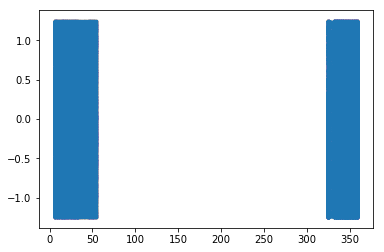

In [6]:
%matplotlib inline
# Find out what is the area by plotting the scatter of ra, dec 
plt.scatter(data['ra'], data['decl'], s=0.002)

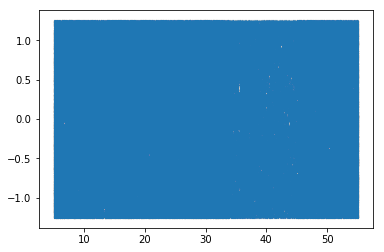

In [7]:
m = data['ra'] < 60
plt.scatter(data['ra'][m], data['decl'][m],s=0.0002)

In [12]:
m = data['ra'] < 60
r1 = np.min(data['ra'][m])
r2 = np.max(data['ra'][m])
print(r1, r2)
print('Delta ra = %f deg'%(r2-r1))

4.95995352314 55.119819687
Delta ra = 50.159866


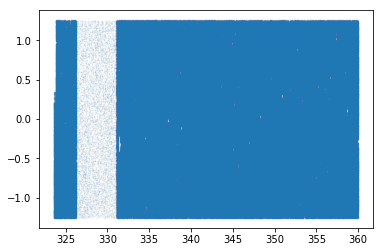

In [8]:
m = data['ra'] > 320
plt.scatter(data['ra'][m], data['decl'][m],s=0.0002)

In [13]:
m = data['ra'] > 320
r1 = np.min(data['ra'][m])
r2 = np.max(data['ra'][m])
print(r1, r2)
print('Delta ra = %f deg'%(r2-r1))

323.579955965 359.999992892
Delta ra = 36.420037 deg


In [14]:
d1,d2 = np.min(data['decl']), np.max(data['decl'])
print(d1,d2)
print(d2-d1)

-1.25669166355 1.25683099732
2.51352266088


In [46]:
import matplotlib.pyplot as plt
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 13

In [47]:
from matplotlib.ticker import AutoMinorLocator
from scipy.stats import binned_statistic
def plot_diff_counts(mag,label, ax, masks_diff_counts, intercept):
    ''' A convenience function to plot the differential counts, 
    i.e. bottom two panels of Fig.1 of Ivezic+2004.  
    
    Input : 
    --------
    mag :  an array with  magnitudes along which to plot the counts 
    label : x-axis label : a string 
    ax : an axis on which to plot the diff counts 
    masks_diff_counts : a list of three masks, each should 
        have the same length as mag, in order 
        [qso, transitional, hot_stars]
    
    Returns:
    --------
    None
    '''
    
    
    colors = ['red', 'green', 'blue']  # symbol colors 
    symbols = ['o', '^', 's'] # https://matplotlib.org/api/markers_api.html
    sizes = [10,6,6]  # symbol sizes 
    dashes = (5,5)
    dm = 0.2 # the spacing for bins along x-axis 
    bins   = np.arange(17,24,dm)    

    for mask, color, symbol, size in zip(masks_diff_counts, colors, symbols, sizes):
        hist, bin_edges = np.histogram(mag[mask], bins=bins, density=False)
        bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
        diff_counts = hist / (area * dm)
        x = bin_centres
        y = diff_counts
        z = np.log10(diff_counts)
        ax.plot(x,z, ls = '-', color=color, marker = symbol,
                markersize=size ,mfc='none') 
        # errors 
        # http://faculty.washington.edu/stuve/log_error.pdf
        stdev  = lambda x: np.std(x)
        stats = binned_statistic( mag[mask], mag[mask], statistic=stdev, bins=bins)
        dy = stats[0] / np.sqrt(hist)  # https://en.wikipedia.org/wiki/Standard_error
        dz= 0.434  * (dy / y)
        ax.errorbar(x,z, dz, fmt='.k', capsize=0)
    
    # more steep diagonal line, the one on the left 
    ax.plot(x[x<22], 0.75*x[x<22] + intercept[0], dashes=dashes, color='blue')
    # less steep diagonal line, the one on the right 
    ax.plot(x[x>18], 0.3*x[x>18] + intercept[1], dashes=dashes, color='blue')
    
    ax.set_ylabel('log(dN / dm / dA [mag'+r'$^{-1}$'+ 'deg'+r'$^{-2}$'+'])')
    ax.set_xlabel(label)

    # make ticks into the axis, longer and thicker... 
    minorLocator = AutoMinorLocator()
    ax.xaxis.set_minor_locator(minorLocator)
    minorLocator = AutoMinorLocator()
    ax.yaxis.set_minor_locator(minorLocator)

    ax.tick_params(which='both', direction='in', width='1')
    ax.tick_params(which='major', length=10)
    ax.tick_params(which='minor', length=5, color='black' ) 
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')



In [61]:

area = (36.42 + 50.159866) * 2.513522
def plot_all_panels(data=None, var=None, bounds=None, area=None, intercept=None):
    ''' A convenience function to plot all four panels 
    from Fig.1 Ivezic+2004. We use a function 
    plot_diff_counts() to plot the differential counts
    (bottom two panels). 
    
    Input: 
    ------
    data :  an AstroPy Table that contains columns with  {u,g,r}+'psfMean_all' , 
    'g'+{chi2DOF, chi2R}+'_all', i.e. all data to plot . Default : None
    
    var : a string that defines how we should cut on variability. NOTE : 
    this applies to ALL the data before plotting, not just selecting QSO! 
    Possible choices include  's0',  's0a', 's1', 's2a', 's2b' : all these
    denote different regions in chi2R - chi2DOF space . Default : None. 
    If var= None, we select only by color.  
    
    bounds : a float or tuple of floats,  that defines chi2 bounds needed 
    for different regions.  For 's0', 's1', 's2a',  bounds is a float, 
    by default = 2 .   For 's0a', it is a tuple of floats  : [1,1.5],  
    [1.5,2] are possible choices
    
    intercept :  a pair of floats allowing to move the diagonal lines 
    on bottom two plots (differential counts) up or down.  It is a tuple
    [intercept1,  intercept2], where the first value defines the intercept 
    for the left line (with slope 0.75), and the second value : for the 
    right line (with slope 0.30) - see Ivezic+2004 Fig.1 for explanation. 
    
    area : area of the patch of the sky from which the data comes , 
    to calculate differential counts [ in square degrees]. 
    
    Returns : 
    ------
    None
    '''
    # make aliases for the data ... 
    suffix = '_all'
    chi2R = data['gchi2R'+suffix].data.data
    chi2DOF = data['gchi2DOF'+suffix].data.data
    extendedness = data['extendedness'].data.data
    g = data['gpsfMean'+suffix].data.data
    r = data['rpsfMean'+suffix].data.data
    u = data['upsfMean'+suffix].data.data

    
    # general cuts : magnitude and color  
    mask_ext = extendedness == 0
    mask_ug = (-0.5 < (u-g)) * ((u-g) < 1.5) 
    mask_u  = u < 23.5
    mask_color = mask_ug * mask_u 
    
    print('The area is %.3f sq.degrees'%area)  
    
    color_title =  ' -0.5 < u-g < 1.5 ,  u< 23.5'
    
    if var :  
        # add variability  cuts ...
        # separation line : ax + b 
        a = 0.375
        a_str = '{0:f}'.format(a).rstrip('0')
        b = -0.25
        b_str = '{0:+f}'.format(b).rstrip('0')
        
        if var is 's0' :
            mask_var = (chi2R < bounds ) * ( chi2DOF < bounds )
            var_title =  r'$ \chi^{2}_{DOF,R}(g) < $' + str(bounds)
        
        if var is 's0a' : 
            mask_var =  (bounds[0]<chi2R)*(chi2R<bounds[1])\
                         *(bounds[0]<chi2DOF)*(chi2DOF<bounds[1])
            var_title =str(bounds[0])+ r'$< \chi^{2}_{DOF,R}(g) < $ '+ str(bounds[1])
            
        if var is 's1' : 
            mask_var = (chi2R > bounds ) * ( chi2DOF > bounds )
            var_title = str(bounds)+ r'$< \chi^{2}_{DOF,R}(g)$'
        if var is 's2a':  
            mask_var = (chi2R < bounds ) * ( chi2DOF > bounds )\
                    * (chi2R >a * chi2DOF +b)
            var_title = str(bounds)+ r'$< \chi^{2}_{DOF}(g),$ ' \
                        +r'$ \chi^{2}_{R}(g)<$'+str(bounds)+', '\
                        +r'$ \chi^{2}_{R}(g)>$'+a_str\
                        +r'$ \chi^{2}_{DOF}(g)$'+b_str

        if var is 's2b' : 
            mask_var = (chi2R < bounds ) * ( chi2DOF > bounds ) \
                    * (chi2R <a * chi2DOF +b)
            var_title = str(bounds)+ r'$< \chi^{2}_{DOF}(g),$ ' \
                        +r'$ \chi^{2}_{R}(g)<$'+str(bounds)+', '\
                        +r'$ \chi^{2}_{R}(g)<$'+a_str\
                        +r'$ \chi^{2}_{DOF}(g)$'+b_str
        
        # combine all the masks 
        m = mask_color * mask_ext * mask_var 
        
        # set the filename ... 
        if var in ['s1', 's2a', 's2b'] : 
            prenom = 'Fig1_'+var+'_gt_'+str(bounds)
        if var is 's0a' : 
            prenom = 'Fig1_'+var+str(bounds[0])+'-'+str(bounds[1])
        if var is 's0' : 
            prenom = 'Fig1_'+var+'_lt_'+str(bounds)
        
        nObj = np.sum(m)
        print('We have %d objects to start with '%nObj)
        # set the title for the top of the panel ... 
        suptitle = 'unresolved, n='+str(nObj)+ color_title+'\n' + ' area='\
                    +str(area)[:5]+'deg'+r'$^{2}$, ' \
                    +var + ': '+ var_title

    else : # use only color cuts ... 
        # set the filename and combine the masks 
        prenom = 'Fig1_only_color'
        m = mask_color * mask_ext 
        nObj = np.sum(m)
        print('We have %d objects to start with '%nObj)
        # set the title for the top of the panel ... 
        suptitle = 'unresolved, n='+str(nObj)+ color_title+'\n' + ' area='\
                    +str(area)[:5]+'deg'+r'$^{2}$ ' + 'color only'

    #########################
    # Plotting  four panels #
    #########################
    
    # initialize plotting space 
    fig,axs = plt.subplots(2,2,figsize=(12,12))
    ax = np.ravel(axs)
    # plot settings : linewidth, linestyle, density and 
    # dash length , dot size 
    lw = 2; ls = '--' ; dashes = (5, 5); dotsize=0.002

    # plot upper left panel  : u-g vs u 
    ug = u[m]-g[m]
    gr = g[m]-r[m]
    ax[0].scatter(ug,u[m], s=dotsize)
    ax[0].invert_yaxis()
    ax[0].set_xlabel('u-g')
    ax[0].set_ylabel('u')
    # plot the two vertical lines at u=0.6 and 0.8 
    ax[0].axvline(0.6, lw=lw, ls=ls, c='r', dashes=dashes)
    ax[0].axvline(0.8, lw=lw, ls=ls, c='r', dashes=dashes)

    # plot upper right panel : u-g vs g-r 
    ax[1].scatter(ug,gr, s=0)
    ax[1].set_ylim(-0.6, 0.7)
    # plot the two vertical lines at u=0.6 and 0.8 
    ax[1].axvline(0.6, lw=lw, ls=ls, dashes=dashes)
    ax[1].axvline(0.8, lw=lw, ls=ls, dashes=dashes)
    ax[1].set_xlabel('u-g')
    ax[1].set_ylabel('g-r')
    # get the lims to plot the horizontal line 
    xmin,xmax = ax[1].get_xlim()
    x1,x2 = 0.3, 0.6
    y1,y2 = -0.15, 0.02
    # plot horizontal line from (xmin,y1) -->  (x1,y1), 
    ax[1].plot([xmin, x1], [y1,y1], ls=ls, lw=lw,  dashes=dashes)

    # plot short diagonal line 
    ax[1].plot([x1,x2],[y1,y2],ls=ls, lw=lw, dashes=dashes, color='blue')
    ax[1].set_xlim(xmin, xmax)
    # find out the equation of diagonal line y = ax + b
    # to limit  g-r and u-g   , since 
    # g-r == y ,  and u-g == x ,  
    # anything above the line  is y > ax + b,   
    # and below the line y < ax + b 
    # which translates to gr >/< a*ug + b
    a_slope = (y2-y1)/(x2-x1)
    b_intercept = y1 - a_slope * x1

    # select quasars by color cut 
    mask_qso = (ug < 0.6 ) * ( -0.15 < gr) * (gr > a_slope*ug + b_intercept)
    ax[1].scatter(ug[mask_qso], gr[mask_qso], s=dotsize, c='r')

    # select transitional region in color space 
    # between quasars and stars 
    mask_trans = (0.6 < ug) * ( ug < 0.8 ) 
    ax[1].scatter(ug[mask_trans], gr[mask_trans], s=dotsize, c='g')

    # select hot stars, including the white dwarfs
    # the triangle is to take care of the white 
    # dwarf branch 
    mask_triangle = (gr < a_slope*ug + b_intercept) \
                    * (ug  < 0.6) * (gr > -0.15)
    mask_bottom = (ug  < 0.6) * (gr < -0.15)
    # logical or 
    mask_hots = mask_triangle | mask_bottom 
    ax[1].scatter(ug[mask_hots], gr[mask_hots], s=dotsize, c='blue')

    # select the rest of objects 
    mask_rest = (0.8 < ug)
    ax[1].scatter(ug[mask_rest], gr[mask_rest], s=dotsize, c='black')

    # plot bottom left and bottom right : diff counts 
    # in u and r 

    # assemble all masks together: settings for the diff counts
    masks_diff_counts = [mask_qso, mask_trans, mask_hots]
    
    for mag, label, ax in zip([u[m], r[m]], ['u','r'], [ax[2], ax[3]]):
        plot_diff_counts(mag,label, ax, masks_diff_counts, intercept )
        
    fig.subplots_adjust(wspace=0.3)
    fig.suptitle(suptitle, fontsize=18 )
    name = outDir + prenom+'.png'
    plt.savefig(name, bbox_inches='tight')
    print('Saved as %s'%name)
    
    ##########################
    # plot only counts in g  #
    ##########################
    
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    mag = g[m] ; label = 'g'
    plot_diff_counts(mag,label, ax, masks_diff_counts, intercept )
    fig.suptitle(suptitle, fontsize=18 )
    name = outDir + prenom+'_g.png'
    plt.savefig(name, bbox_inches='tight')
    print('Saved as %s'%name)

In [62]:

outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_Ivezic2004',
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
print('We will save this figure in  %s'%outDir)


We will save this figure in  /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Ivezic2004/2017-06-09/


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in greater
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in less
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in less


The area is 217.620 sq.degrees
We have 171172 objects to start with 


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in log10


Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Ivezic2004/2017-06-09/Fig1_only_color.png


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in log10


Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Ivezic2004/2017-06-09/Fig1_only_color_g.png


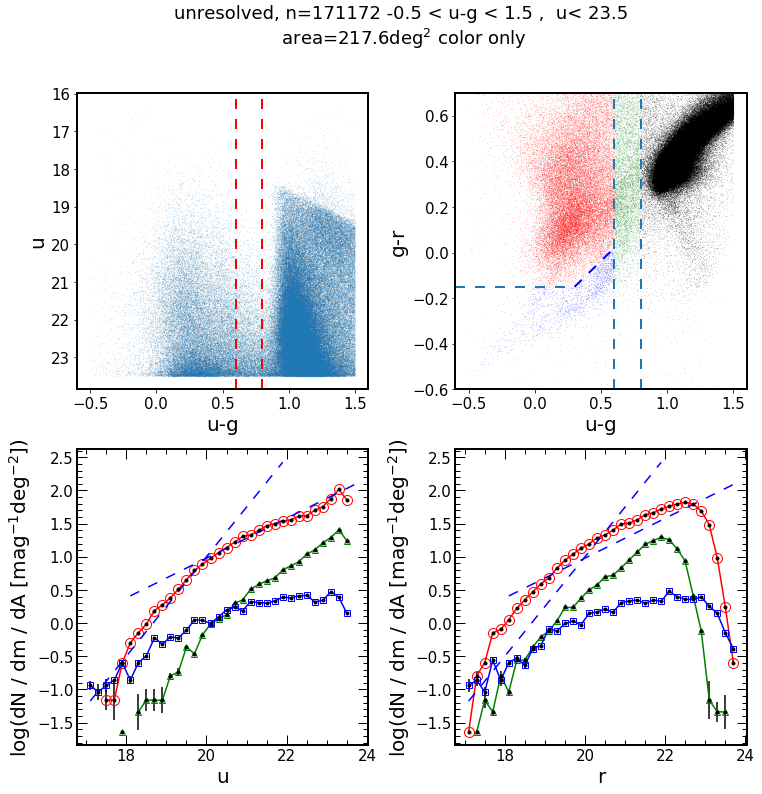

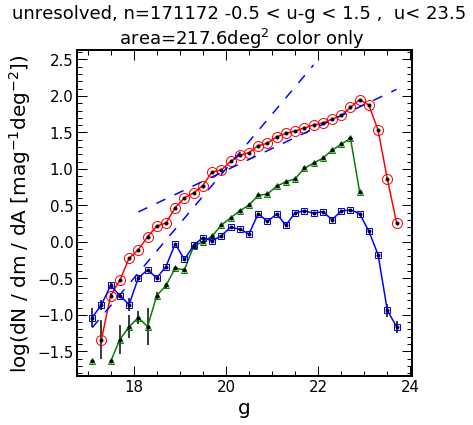

In [63]:
plot_all_panels(data, var=None, bounds=None, intercept=[-14,-5.02] , area=area)